In [1]:
import os
import sys
import time
import itertools
from collections import defaultdict
import numpy as np

# Torch
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
print("Torch Version:", torch.__version__)

sys.path.append("../../utils/")
from PriorityQueue import PriorityQueue

# Simple RL
from simple_rl.tasks import NavigationWorldMDP
from simple_rl.tasks.navigation.NavigationStateClass import NavigationWorldState

import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable
# style.use('classic')
%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 55

%matplotlib inline
%load_ext autoreload
%autoreload 2

Torch Version: 0.5.0a0+ab6afc2


In [2]:
def log_boltzmann_dist(Q, temperature):
    """
    PyTorch softmax implementation seems stable, but log of softmax is not. 
    So log of boltzmann distribution is used.
    PyTorch Softmax Note:
        This function doesn't work directly with NLLLoss,
        which expects the Log to be computed between the Softmax and itself.
        Use log_softmax instead (it's faster and has better numerical properties).
    """
    return nn.LogSoftmax(dim=0)(Q/temperature)

def run_differentiable_value_iteration(S, A, R, T, gamma, n_iters, 
                                       goal, convergence_eps=1e-3, 
                                       boltzmann_temp=1e-4, dtype=torch.float32):
    
    # assert torch.all(R < 0)
    nS, nA = len(S), len(A)
    v_delta_max = float("inf")
    s_to_idx = {tuple(v):k for k,v in enumerate(S)}
    a_to_idx = {a:i for i,a in enumerate(A)}
    Q = torch.zeros(nS, nA, dtype=dtype)
    log_Pi = torch.log(torch.ones(nS, nA, dtype=dtype) / nA)
    # requires_grad = False isn't enough, so also detach tensor.
    # (reason: https://github.com/pytorch/pytorch/issues/166)
    V = torch.tensor(R, requires_grad=False)
    
    # Given goal
    goal_state_idx = s_to_idx[tuple(goal)]
    V[goal_state_idx] = 0
    
    print("Running VI [\n\t", end="")
    iterno = 0
    while iterno < n_iters and v_delta_max > convergence_eps:
        
        print(".", end="")
        if iterno and iterno % 50 == 0: print("\n\t", end="")
        
        v_delta_max = 0
        for si, s in enumerate(S):
            
            v_s_prev = V[si].detach().item()
            if si == goal_state_idx or s.is_terminal():
                continue
            
            max_q = float("-inf")
            for ai, a in enumerate(A):
                
                s_prime = T(s,a)
                
                if s_prime is None: # outside envelope
                    continue
                    
                Q[si, ai] = R[si] + gamma * V[s_to_idx[tuple(s_prime)]].clone()
                q_s_a = Q[si, ai].detach().item()
                max_q = q_s_a if q_s_a > max_q else max_q
                
            log_Pi[si, :] = log_boltzmann_dist(Q[si, :].clone(), boltzmann_temp)
            V[si] = torch.exp(log_Pi[si, :].clone()).dot(Q[si, :].clone())
            
            v_delta_max = max(abs(v_s_prev - V[si].detach().item()), v_delta_max)
        
        iterno += 1
        
    if iterno == n_iters:
        print("]\n\t-> VI max iterations reached @ {}.".format(iterno))
    else:
        print("]\n\t-> VI converged @ {}.".format(iterno))
        
    return log_Pi, V, Q, s_to_idx, a_to_idx

# def sample_trajectory(S, A, T, start_state, policy, given_goal, 
#                       horizon=1000, greedy_selection=True):
    
#     s_list = []
#     a_list = []
    
#     # state tuple -> idx
#     s_to_idx = {tuple(v):k for k,v in enumerate(S)}
#     given_goal_idx = s_to_idx[tuple(given_goal)]
#     steps = 0
    
#     ## start state
#     s = start_state
    
#     while steps < horizon:
        
#         ## add state
#         s_idx = s_to_idx[tuple(s)]
#         s_list.append(S[s_idx])
        
#         ## sample next state
        
#         # policy  (Note: taking exp because the policy is log softmax)
#         Pi_s = torch.exp(policy[s_idx]).detach().numpy()
#         # action selection
#         if greedy_selection:
#             a_idx = int(Pi_s.argmax())
#         else:
#             a_idx = int(np.random.choice(len(A), p=Pi_s))
        
#         a_list.append(A[a_idx])
#         s = T(S[s_idx], A[a_idx])
        
#         steps += 1
        
#         # check if goal is given and reached
#         if given_goal_idx is not None and s_idx == given_goal_idx:
#             break
            
#     return  s_list, a_list

# def sample_trajectories(N, S, A, T, start_states, policy, given_goal, 
#                         horizon=1000, greedy_selection=True):
    
#     traj_list = []
    
#     for i in range(N):
        
#         s_list, a_list = sample_trajectory(S, A, T, start_states[i], policy, given_goal, horizon, greedy_selection)
#         traj_list.append((s_list, a_list))
        
#     return traj_list

# def get_min_value_estimate_given_goal_greedy(max_traj_length, driving_cost, gamma):
    
#     min_value = 0.
#     for i in range(max_traj_length):
#         min_value -= (gamma**i) * driving_cost
#     return min_value

def likelihood(log_Pi, traj_list, s_to_idx, a_to_idx):
    
    lik = 0.
    # n_sa = 0.
    for (s_list, a_list) in traj_list:
        for i in range(len(s_list)):
            s, a = s_list[i], a_list[i]
            lik += log_Pi[s_to_idx[tuple(s)]][a_to_idx[a]]
            # n_sa += 1
    return lik

def log_likelihood(Pi, traj_list, s_to_idx, a_to_idx):
    
    loglik = 0.
    # n_sa = 0.
    for (s_list, a_list) in traj_list:
        for i in range(len(s_list)):
            s, a = s_list[i], a_list[i]
            loglik += torch.log(Pi[s_to_idx[tuple(s)]][a_to_idx[a]])
            # n_sa += 1
    return loglik

# Visualization functions 
import io
import imageio
from PIL import Image
from IPython import display

def read_pil_image_from_plt(plt):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return Image.open(buf)

def create_gif(img_generator, cmap=plt.cm.viridis, gif_name="./__gif_sample.gif", fps=10,
               figsize=(4, 4), title=None, display=False):
    with imageio.get_writer(gif_name, mode='I', fps=fps) as writer:
        for img in img_generator():
            # Append to GIF
            writer.append_data(np.array(img))
            
            # Wait to draw - only for online visualization
            if display:
                plt.imshow(img)
                display.clear_output(wait=True)
                display.display(plt.gcf())
        plt.clf()
    return

def convert_to_grid(nvmdp, S, state_values):
    
    grid = np.zeros((nvmdp.height, nvmdp.width))
    
    for si, s in enumerate(S):
        x, y = s
        row, col = nvmdp._xy_to_rowcol(x, y)
        grid[row, col] = state_values[si]
    return grid

def get_grad_evolution_images(nvmdp, S, R_grid, expert_traj, R_grads_evolution, boltzmann_temp, 
                              figsize=(40,20), R_kind=""):

    for i in range(len(R_grads_evolution)):
        
        plt.close('all')
        plt.figure(figsize=figsize)
        nvmdp.visualize_grid(R_grid, trajectories=expert_traj, cmap=plt.cm.Reds_r,
                             state_space_cmap=False, show_colorbar=True, fig=fig, subplot_str="121",
                             title="Navigation IRL MDP(with true reward). Expert Path (black).", end_marker="*c")
        nvmdp.visualize_grid(convert_to_grid(nvmdp, S, R_grads_evolution[i]), trajectories=[expert_traj[0][:i+1]], 
                             state_space_cmap=False,  traj_marker='-b',
                             cmap=plt.cm.Reds_r, show_colorbar=True, fig=fig, subplot_str="122",
                             title="MLIRL Gradients. {}, temp: {}, step: {}.".format(R_kind, boltzmann_temp, i+1))
        yield read_pil_image_from_plt(plt)
        plt.clf()

In [3]:
class RectangularObstacle(object):
    
    def __init__(self, x, y, w, h):
        
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.points = [(x+i, y+j) for j in range(h) for i in range(w)]
    
    def intersects(self, o2):
        
        x1, y1, w1, h1 = o2.x, o2.y ,o2.w, o2.h
        
        # check if rect is on the left or right side of another one
        if self.x + self.w < x1\
            or self.x > x1 + w1:
            return False
        
        # check if rect is on the top or bottom side of another one
        if self.y + self.h < y1 \
            or self.y > y1 + h1:
            return False
        
        return True
    
    def __eq__(self, o2):
        return self.intersects(o2)
        
    def __call__(self):
        return self.points
    
    def __repr__(self):
        return "Obstacle at (x,y) = ({},{}) of size (w,h) = ({},{})".format(self.x, self.y, self.w, self.h)


def get_action_from_state_change(state, n_state):
    
    dx = n_state[0] - state[0]
    dy = n_state[1] - state[1]
    if dx > 0 and dy == 0: return "right"
    elif dx > 0 and dy > 0: return "up-right"
    elif dx == 0 and dy > 0: return "up"
    elif dx < 0 and dy > 0: return "up-left"
    elif dx < 0 and dy == 0: return "left"
    elif dx < 0 and dy < 0: return "down-left"
    elif dx == 0 and dy < 0: return "down"
    elif dx > 0 and dy < 0: return "down-right"
    else: return "stay"
    
def generate_obstacles(grid_w, grid_h, n_obstacles, 
                       obstacle_w_mu=3, obstacle_w_std=3,
                       obstacle_h_mu=3, obstacle_h_std=3,
                       max_search_tries=100):

    obstacle_list = []
    count = 0
    search_tries = 0
    while count < n_obstacles:
        
        w = int(min(max(np.ceil(np.random.normal(obstacle_w_mu, obstacle_w_std)), 1), grid_w-1))
        h = int(min(max(np.ceil(np.random.normal(obstacle_h_mu, obstacle_h_std)), 1), grid_h-1))
        
        # restrict x, y so that obstacle is inside the desired region
        x, y = np.random.randint(1, grid_w-w+1), np.random.randint(1, grid_h-h+1)
        
        ob = RectangularObstacle(x, y, w, h)
        
        if ob not in obstacle_list:
            obstacle_list.append(ob)
            count += 1
            search_tries = 0
        else:
            search_tries += 1
            if search_tries < max_search_tries:
                continue
            else:
                print("Couldn't find space for more obstacles. Generated: {}".format(count))
                break
        
    return obstacle_list

heuristic_l2 = lambda s1, s2: np.linalg.norm(np.array(s1) - np.array(s2))
def astar_find_path(start, goal, actions, trans_func, cost_fn=lambda s: 1, heuristic_fn=heuristic_l2):
    
    frontier = PriorityQueue()
    frontier.append([cost_fn(start)+heuristic_fn(start, goal), cost_fn(start), start])
    explored = defaultdict(lambda: False)
    cost = defaultdict(lambda: np.float("inf"))
    parent = defaultdict(lambda: None)
    path = []
    
    while frontier.size():
        
        f, g, s = frontier.pop()
        explored[s] = True
        
        if s == goal:
            
            curr_state = goal
            s_list = [curr_state]
            a_list = [None]
            parent_state = parent[curr_state] # greedy selection
            
            while parent_state is not None:
                
                s_list.append(parent_state)
                a_list.append(get_action_from_state_change(parent_state, curr_state))
                
                curr_state = parent_state
                parent_state = parent[curr_state] # greedy selection
                
            return list(zip(s_list[::-1], a_list[::-1]))
        
        for a in actions:
            
            sp = trans_func(s, a)
            if not explored[sp] and sp not in frontier:
                
                g_new = g + cost_fn(sp)
                f_new = g_new + heuristic_fn(sp, goal)
                
                # prevent cycles
                if g_new < cost[sp]:
                    frontier.append((f_new, g_new, sp))
                    parent[sp] = s
                    cost[sp] = g_new
    return None
# traj = astar_find_path(S[0], S[10], A, T, cost_fn=lambda s: -R_s(s))

def sample_trajectories(start_states, goal_states, 
                        shortest_path_fn = lambda s, g: astar_find_path(s, g, A, T, cost_fn=lambda s: -R_s(s))):
    
    traj_list = []
    for i in range(len(start_states)):
        start = start_states[i]
        goal = goal_states[i]
        traj_list.append(shortest_path_fn(start, goal))
    return traj_list 

def state_id_to_linear_feature(state_id):
    
    sigma = 0.1
    
    if state_id == 0: # drivable 
        if np.random.random() > 0.5:
            mu1 = -0.5
            mu2 = -0.5
        else:
            mu1 = -0.5
            mu2 = 0.5
        return [np.random.normal(mu1, sigma), np.random.normal(mu2, sigma)]
    else: # obstacle
        if np.random.random() > 0.5:
            mu1 = 0.5
            mu2 = -0.5
        else:
            mu1 = 0.5
            mu2 = 0.5
        return [np.random.normal(mu1, sigma), np.random.normal(mu2, sigma)]
    

def state_id_to_non_linear_feature(state_id):
    
    sigma = 0.1
    
    if state_id == 0: # drivable 
        if np.random.random() > 0.5:
            mu1 = -0.5
            mu2 = -0.5
        else:
            mu1 = 0.5
            mu2 = 0.5
        return [np.random.normal(mu1, sigma), np.random.normal(mu2, sigma)]
    else: # obstacle
        if np.random.random() > 0.5:
            mu1 = -0.5
            mu2 = 0.5
        else:
            mu1 = 0.5
            mu2 = -0.5
        return [np.random.normal(mu1, sigma), np.random.normal(mu2, sigma)]

In [169]:
class NavigationWorldMDP_8_actions(NavigationWorldMDP):
    
    ACTIONS = ["up", "down", "left", "right", "up-left", "up-right", "down-left", "down-right"]
    
    
    def _transition_func(self, state, action):
        """
        Args:
            state (State)
            action (str)

        Returns
            (State)
        """
        if state.is_terminal():
            return state

        if action == "up" and state.y < self.height and not self.is_wall(
                state.x, state.y + 1):
            next_state = NavigationWorldState(state.x, state.y + 1)
        elif action == "down" and state.y > 1 and not self.is_wall(
                state.x, state.y - 1):
            next_state = NavigationWorldState(state.x, state.y - 1)
        elif action == "right" and state.x < self.width and not self.is_wall(
                state.x + 1, state.y):
            next_state = NavigationWorldState(state.x + 1, state.y)
        elif action == "left" and state.x > 1 and not self.is_wall(state.x - 1,
                                                                   state.y):
            next_state = NavigationWorldState(state.x - 1, state.y)
            
        elif action == "up-left" and state.y < self.height and state.x > 1 \
            and not self.is_wall(
                state.x - 1, state.y + 1):
            next_state = NavigationWorldState(state.x - 1, state.y + 1)
        elif action == "up-right" and state.y < self.height and state.x < self.width \
            and not self.is_wall(
                state.x + 1, state.y + 1):
            next_state = NavigationWorldState(state.x + 1, state.y + 1)
            
        elif action == "down-left" and state.y > 1 and state.x > 1 \
            and not self.is_wall(
                state.x - 1, state.y - 1):
            next_state = NavigationWorldState(state.x - 1, state.y - 1)
        elif action == "down-right" and state.y > 1 and state.x < self.width \
            and not self.is_wall(
                state.x + 1, state.y - 1):
            next_state = NavigationWorldState(state.x + 1, state.y - 1)
        else:
            next_state = NavigationWorldState(state.x, state.y)

        if self.is_goal(next_state.x, next_state.y) and self.is_goal_terminal:
            next_state.set_terminal(True)

        return next_state

## Navigation Grid World

Couldn't find space for more obstacles. Generated: 7


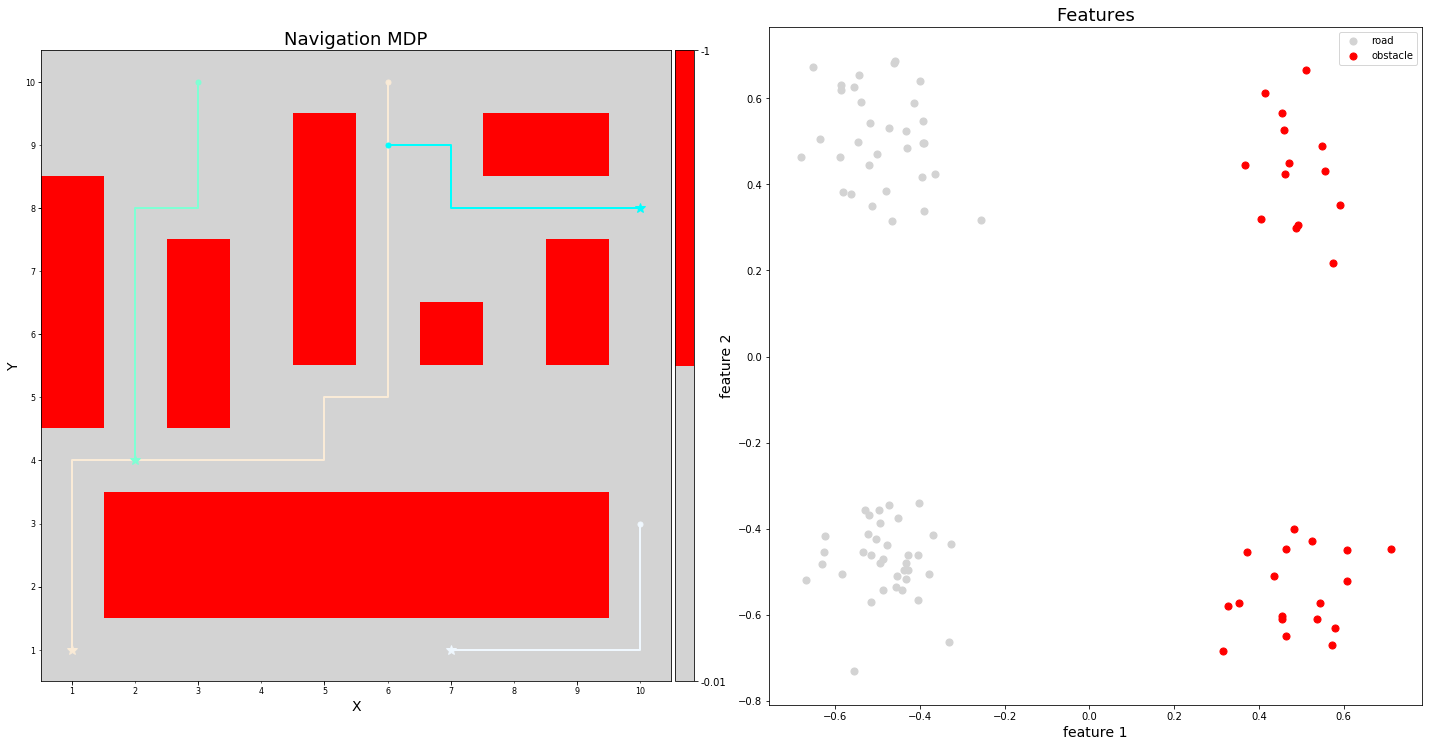

In [303]:
np.random.seed(1)
torch.manual_seed(1)

obstacle = lambda x, y, w, h: [(x+i, y+j) for j in range(h) for i in range(w)]

W, H = 10, 10
n_obstacles = 10

nvmdp = NavigationWorldMDP(
    
    width = W, height = H,
    nav_cell_types = ['lightgrey', "red"],
    nav_cell_rewards = [-0.01, -1],
    nav_cell_p_or_locs = [1., 
                          list(itertools.chain(*[o() for o in generate_obstacles(
                              W, H, n_obstacles, max_search_tries=100)]))],
    goal_cell_types = [],
    goal_cell_rewards = [],
    goal_cell_locs = [],
    slip_prob = 0.0, step_cost = 0,
    gamma = 0.95
)
S = nvmdp.get_all_states()
s_to_idx = {tuple(v):k for k,v in enumerate(S)}
R_s = nvmdp._reward_func_state_only
R = torch.tensor([R_s(s) for s in S], requires_grad=True)
R_grid = convert_to_grid(nvmdp, S, R)
A = nvmdp.get_actions()
a_to_idx = {a:i for i,a in enumerate(A)}
T = nvmdp.transition_func

# assert len(astar_find_path(S[0], S[10], A, T, cost_fn=lambda s: -R_s(s))) == 13


# Features
state_ids = [nvmdp.map_state_cell_id[tuple(nvmdp._xy_to_rowcol(*s))] for s in S]
linear_phi = torch.FloatTensor([state_id_to_linear_feature(s_id) for s_id in state_ids])
non_linear_phi = torch.FloatTensor([state_id_to_non_linear_feature(s_id) for s_id in state_ids])

phi = linear_phi
phi_fn = lambda s: phi[s_to_idx[tuple(s)]]

# Sample demonstrations
n_traj = 4
nvmdp.set_traj_init_cell_types(["lightgrey"])
trajectories = sample_trajectories(nvmdp.sample_init_states(n_traj), nvmdp.sample_init_states(n_traj))
trajectories_states = [list(zip(*traj))[0] for traj in trajectories]
assert not trajectories[0][-1][1]

# nvmdp.visualize_grid(trajectories=trajectories_states,
#                      state_space_cmap=True, 
#                      show_rewards_colorbar=True,
#                      cmap=plt.cm.Reds_r,
#                      show_colorbar=True, 
#                      init_marker=".",
#                      end_marker="*",
#                      traj_linewidth=1,
#                      traj_marker="-k",
#                      traj_colors_auto=True)

"""
Ref: https://stackoverflow.com/questions/47006268/matplotlib-scatter-plot-with-color-label-and-legend-specified-by-c-option
"""
fig = plt.figure(figsize=(20,10))
cdict = {0: "lightgrey", 1: "red"}
group = state_ids
labels = {0: "road", 1: "obstacle"}
ax = fig.add_subplot("121")
fig, ax = nvmdp.visualize_grid(trajectories=trajectories_states, 
                     state_space_cmap=True,
                     show_rewards_colorbar = True,
                     cmap=plt.cm.Reds_r, 
                     show_colorbar=True, 
                     init_marker=".",
                     end_marker="*", 
                     traj_linewidth=2,
                     fig=fig, ax=ax, plot=False)

ax = fig.add_subplot("122")

for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(phi[ix,0], phi[ix,1], c = cdict[g], label = labels[g], s = 50)
# plt.scatter(phi[:,0], phi[:,1], c=[colors[s] for s in state_ids], g=state_ids, label=["obstacle", "drivable"])
plt.tight_layout()
plt.title("Features")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend()

In [324]:
def states_generator(trajectory):
    return S

def dynamics_generator(trajectory):
    return T

# Linear features
class LinearRewardModel_Tanh(nn.Module):
    
    def __init__(self, phi_dim):
        super().__init__()
        self.w = nn.Linear(phi_dim, 1, bias=True)
        self.tanh = nn.Tanh()
        
    def forward(self, phi):
        return self.tanh(self.w(phi)) - 1.1 # Force R to be non-positive
    
    
class LinearRewardModel_ReLU(nn.Module):
    
    def __init__(self, phi_dim):
        super().__init__()
        self.w = nn.Linear(phi_dim, 1, bias=True)
        self.relu = nn.ReLU()
        
    def forward(self, phi):
        return -self.relu(-self.w(phi)) - 0.1 # Force R to be non-positive

In [325]:
def MLIRL(trajectory_list, states_generator_fn, dynamics_generator_fn, A, phi, R_model, R_optimizer, 
          gamma,boltzmann_temp=0.1, n_iters=20, max_vi_iters=100, 
          vi_convergence_eps=0.001, mlirl_convergence_eps=1e-3, dtype=torch.float32,
          verbose=True, print_interval=1):
    
    loss_history = []
    
    for _iter in range(n_iters):
        
        # mlirl iter tick
        _mlirl_iter_start = time.time()
            
        # Zero grads
        R_optimizer.zero_grad()
            
        loss = 0
        n_sa = 0
        for idx, trajectory in enumerate(trajectory_list):
            
            goal = trajectory[-1][0]
            S = states_generator_fn(trajectory)
            T = dynamics_generator_fn(trajectory)
            R = [R_model(phi(s)).type(dtype) for s in S]
            
            # Compute Policy
            log_Pi, V, Q, s_to_idx, a_to_idx = run_differentiable_value_iteration(
                S, A, R, T, gamma, max_vi_iters, goal, 
                convergence_eps=vi_convergence_eps, 
                boltzmann_temp=boltzmann_temp, dtype=dtype)
            
            # Maximize data likelihood objective
            for (s,a) in trajectory[:-1]:
                s_idx = s_to_idx[tuple(s)]
                a_idx = a_to_idx[a]
                loss -= log_Pi[s_idx, a_idx]
                n_sa += 1
                
        loss =  (1/n_sa) * loss
        loss.backward()
        loss_history.append(loss.detach().item())
        # Gradient step
        R_optimizer.step()
        
        if verbose and (_iter % print_interval == 0 or _iter == n_iters-1):
            print("\n>>> Iter: {:04d}: loss = {:09.6f}, likelihood = {:02.4f}, CPU time = {:f}".format(
                _iter, loss, np.exp(-loss.item()), time.time()-_mlirl_iter_start))
                
        if mlirl_convergence_eps is not None and loss < mlirl_convergence_eps:
            print("\n>>> Iter: {:04d} Converged.\n\n".format(_iter))
            break
        
    return loss_history

## Linearly separable features

In [326]:
lr, weight_decay = 0.1, 1e-3
phi_dim = len(phi_fn(S[0]))
gamma = 0.95
n_vi_iters = 30
n_mlirl_iters = 10
temperature = 0.1

R_model_tanh = LinearRewardModel_Tanh(phi_dim)
R_model_relu = LinearRewardModel_ReLU(phi_dim)

In [327]:
R = [R_model_tanh(phi_fn(s)).type(torch.float32).item() for s in states_generator(trajectories[0])]

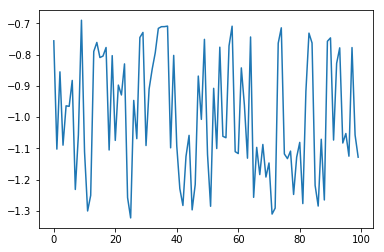

In [328]:
plt.plot(R)

In [329]:
R = [R_model_relu(phi_fn(s)).type(torch.float32).item() for s in states_generator(trajectories[0])]

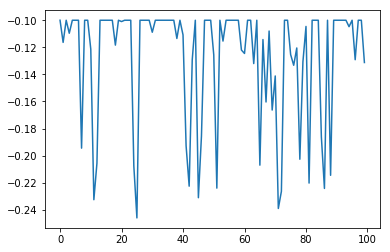

In [330]:
plt.plot(R)

In [331]:
# R model
R_model = R_model_tanh
# Test: non-positive R
assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)
# MLIRL
loss_history_tanh = MLIRL(
    trajectories, states_generator, dynamics_generator, A, phi_fn, R_model, R_optimizer, 
    gamma, temperature, n_mlirl_iters, n_vi_iters)


Running VI [
	......................]
	-> VI converged @ 22.
Running VI [
	........................]
	-> VI converged @ 24.
Running VI [
	.......................]
	-> VI converged @ 23.
Running VI [
	.................]
	-> VI converged @ 17.

>>> Iter: 0000: loss = 00.621808, likelihood = 0.5370, CPU time = 6.311634
Running VI [
	.....................]
	-> VI converged @ 21.
Running VI [
	.......................]
	-> VI converged @ 23.
Running VI [
	......................]
	-> VI converged @ 22.
Running VI [
	..................]
	-> VI converged @ 18.

>>> Iter: 0001: loss = 00.407210, likelihood = 0.6655, CPU time = 6.506103
Running VI [
	.....................]
	-> VI converged @ 21.
Running VI [
	......................]
	-> VI converged @ 22.
Running VI [
	.....................]
	-> VI converged @ 21.
Running VI [
	.................]
	-> VI converged @ 17.

>>> Iter: 0002: loss = 00.280267, likelihood = 0.7556, CPU time = 6.578832
Running VI [
	.....................]
	-> VI converged

In [332]:
lr, weight_decay = 0.1, 1e-3

In [ ]:
# R model
R_model = R_model_relu
# Test: non-positive R
assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)
# MLIRL
loss_history_relu = MLIRL(
    trajectories, states_generator, dynamics_generator, A, phi_fn, R_model, R_optimizer, 
    gamma, temperature, n_mlirl_iters, n_vi_iters)


Running VI [
	......................]
	-> VI converged @ 22.
Running VI [
	.......................]
	-> VI converged @ 23.
Running VI [
	.........................]
	-> VI converged @ 25.
Running VI [
	..................]
	-> VI converged @ 18.

>>> Iter: 0000: loss = 00.522704, likelihood = 0.5929, CPU time = 6.852583
Running VI [
	............................]
	-> VI converged @ 28.
Running VI [
	.............................]
	-> VI converged @ 29.
Running VI [
	..............................]
	-> VI max iterations reached @ 30.
Running VI [
	......................]
	-> VI converged @ 22.

>>> Iter: 0001: loss = 00.475518, likelihood = 0.6216, CPU time = 8.720116
Running VI [
	..............................]
	-> VI max iterations reached @ 30.
Running VI [
	..............................]
	-> VI max iterations reached @ 30.
Running VI [
	..............................]
	-> VI max iterations reached @ 30.
Running VI [
	......................]
	-> VI converged @ 22.

>>> Iter: 0002: lo

In [ ]:
R_grid_tanh = convert_to_grid(nvmdp, S, [R_model_tanh(phi_fn(s)).item() for s in S])
R_grid_relu = convert_to_grid(nvmdp, S, [R_model_relu(phi_fn(s)).item() for s in S])

In [ ]:
fig = plt.figure(figsize=(20,20))
cdict = {0: "lightgrey", 1: "red"}
group = state_ids
labels = {0: "ground", 1: "obstacles"}
ax = fig.add_subplot("321")
fig, ax = nvmdp.visualize_grid(
                     trajectories=trajectories_states, 
                     state_space_cmap=True,
                     show_rewards_colorbar = True,
                     cmap=plt.cm.Reds_r, 
                     show_colorbar=True, 
                     init_marker=".",
                     end_marker="*", 
                     traj_linewidth=2,
                     fig=fig, ax=ax, plot=False)

ax = fig.add_subplot("322")

for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(phi[ix,0], phi[ix,1], c = cdict[g], label = labels[g], s = 50)
# plt.scatter(phi[:,0], phi[:,1], c=[colors[s] for s in state_ids], g=state_ids, label=["obstacle", "drivable"])
# plt.tight_layout()
plt.title("Features")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend()


ax = fig.add_subplot("323")
fig, ax = nvmdp.visualize_grid(R_grid_tanh, trajectories=trajectories_states, 
                     state_space_cmap=False,
                     show_rewards_colorbar=False,
                     cmap=plt.cm.gray, 
                     show_colorbar=True, 
                     init_marker=".",
                     end_marker="*", 
                     traj_linewidth=2,
                     fig=fig, ax=ax, plot=False, title="MLIRL (R model: linear+Tanh): Recovered Reward")

ax = fig.add_subplot("324")
plt.plot(np.exp(-np.asarray(loss_history_tanh)))
plt.xlabel("Iterations")
plt.ylabel("Likelihood")
plt.title("MLIRL (R model: linear+Tanh): Training Curve")

ax = fig.add_subplot("325")
fig, ax = nvmdp.visualize_grid(R_grid_relu, trajectories=trajectories_states, 
                     state_space_cmap=False,
                     show_rewards_colorbar=False,
                     cmap=plt.cm.gray, 
                     show_colorbar=True, 
                     init_marker=".",
                     end_marker="*", 
                     traj_linewidth=2,
                     fig=fig, ax=ax, plot=False, title="MLIRL (R model: linear+ReLU): Recovered Reward")

ax = fig.add_subplot("326")
plt.plot(np.exp(-np.asarray(loss_history_relu)))
plt.xlabel("Iterations")
plt.ylabel("Likelihood")
plt.title("MLIRL (R model: linear+ReLU): Training Curve")

In [290]:
R_model_tanh.w.weight


Parameter containing:
tensor([[-1.3647,  0.0375]], requires_grad=True)

In [291]:
R_model_relu.w.weight

Parameter containing:
tensor([[-0.4271, -0.1185]], requires_grad=True)

## Linearly inseparable features

In [161]:
phi = non_linear_phi
phi_fn = lambda s: phi[s_to_idx[tuple(s)]]

In [162]:
def states_generator(trajectory):
    return S

def dynamics_generator(trajectory):
    return T

# Linear features
class LinearRewardModel(nn.Module):
    
    def __init__(self, phi_dim):
        super().__init__()
        self.w = nn.Linear(phi_dim, 1, bias=True)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
    def forward(self, phi):
        return -self.relu(-self.w(phi)) # Force R to be non-positive
    
#     def forward(self, phi):
#         return self.tanh(self.w(phi)) - 1 # Force R to be non-positive

In [163]:
phi_dim = len(phi_fn(S[0]))
R_model = LinearRewardModel(phi_dim)
# Test: non-positive R
assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)

In [164]:
lr, weight_decay = 0.1, 1e-8
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

In [165]:
loss_history = MLIRL(
    trajectories, states_generator, dynamics_generator, A, phi_fn, R_model, R_optimizer, 0.95, 0.01, 30, 30)

Running VI [
	..]
	-> VI converged @ 2.
Running VI [
	..]
	-> VI converged @ 2.
Running VI [
	..]
	-> VI converged @ 2.
Running VI [
	..]
	-> VI converged @ 2.

>>> Iter: 0000: loss = 01.254177, likelihood = 0.2853, CPU time = 0.621215
Running VI [
	..]
	-> VI converged @ 2.
Running VI [
	..]
	-> VI converged @ 2.
Running VI [
	..]
	-> VI converged @ 2.
Running VI [
	..]
	-> VI converged @ 2.

>>> Iter: 0001: loss = 01.239361, likelihood = 0.2896, CPU time = 0.655182
Running VI [
	..]
	-> VI converged @ 2.
Running VI [
	..]
	-> VI converged @ 2.
Running VI [
	..]
	-> VI converged @ 2.
Running VI [
	..]
	-> VI converged @ 2.

>>> Iter: 0002: loss = 01.482623, likelihood = 0.2270, CPU time = 0.674067
Running VI [
	..]
	-> VI converged @ 2.
Running VI [
	..]
	-> VI converged @ 2.
Running VI [
	..]
	-> VI converged @ 2.
Running VI [
	..]
	-> VI converged @ 2.

>>> Iter: 0003: loss = 01.238338, likelihood = 0.2899, CPU time = 0.672324
Running VI [
	.]
	-> VI converged @ 1.
Running VI [
	.]


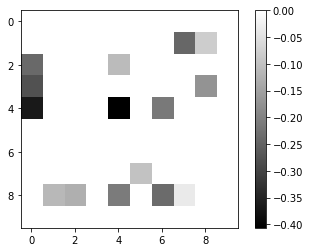

In [166]:
R_grid = convert_to_grid(nvmdp, S, [R_model(phi_fn(s)).item() for s in S])
plt.imshow(R_grid, cmap="gray")
plt.colorbar()

In [167]:
R_grid_relu = R_grid.copy()
loss_history_relu = loss_history.copy()

In [155]:
R_grid_tanh = R_grid.copy()
loss_history_tanh = loss_history.copy()

Text(0.5,1,'MLIRL (ReLU): Training Curve')

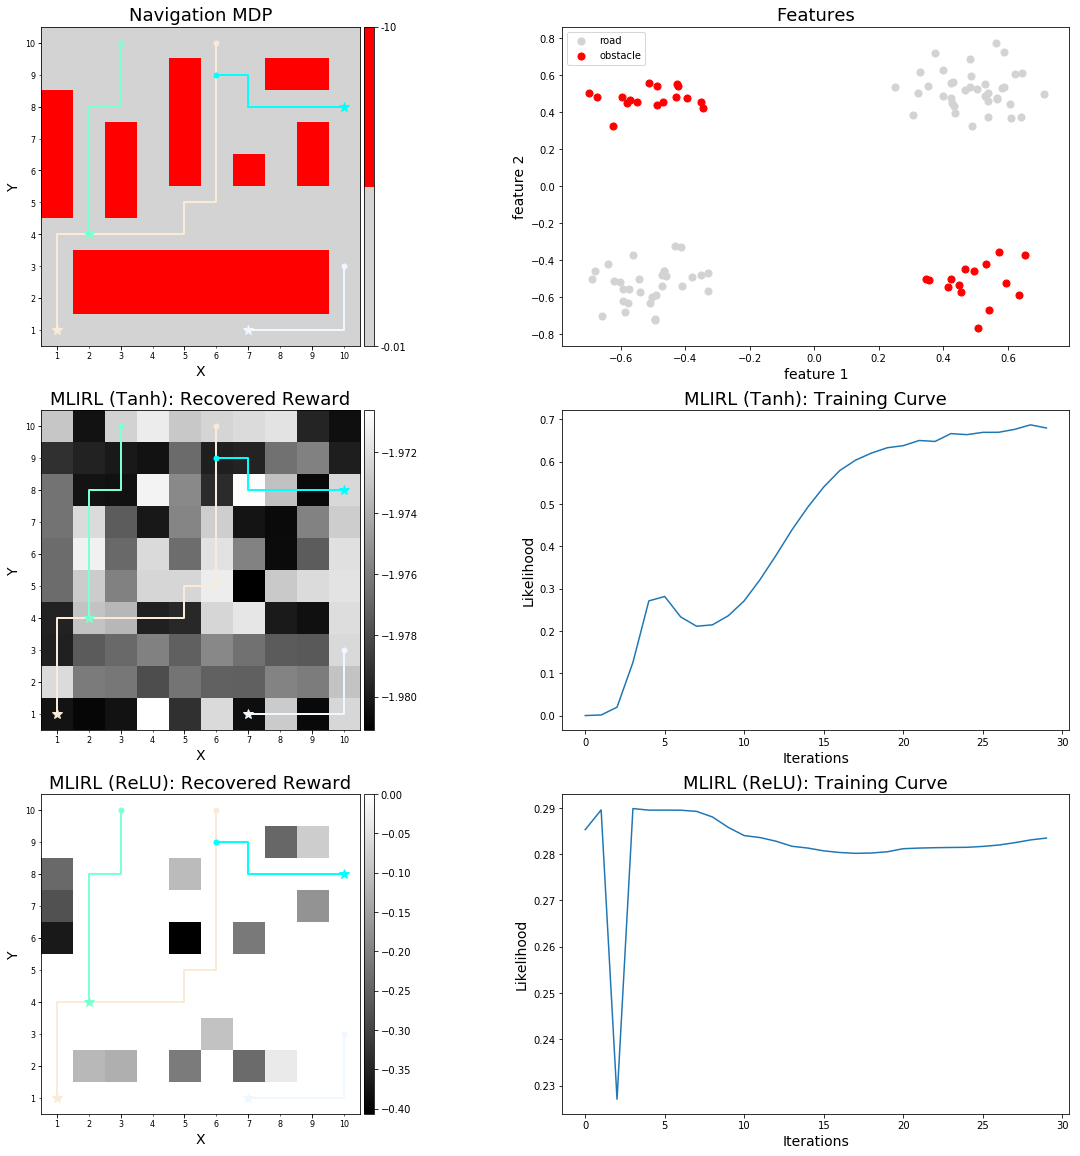

In [168]:
fig = plt.figure(figsize=(20,20))
cdict = {0: "lightgrey", 1: "red"}
group = state_ids
labels = {0: "road", 1: "obstacle"}
ax = fig.add_subplot("321")
fig, ax = nvmdp.visualize_grid(trajectories=trajectories_states, 
                     state_space_cmap=True,
                     show_rewards_colorbar = True,
                     cmap=plt.cm.Reds_r, 
                     show_colorbar=True, 
                     init_marker=".",
                     end_marker="*", 
                     traj_linewidth=2,
                     fig=fig, ax=ax, plot=False)

ax = fig.add_subplot("322")

for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(phi[ix,0], phi[ix,1], c = cdict[g], label = labels[g], s = 50)
# plt.scatter(phi[:,0], phi[:,1], c=[colors[s] for s in state_ids], g=state_ids, label=["obstacle", "drivable"])
# plt.tight_layout()
plt.title("Features")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend()


ax = fig.add_subplot("323")
fig, ax = nvmdp.visualize_grid(R_grid_tanh, trajectories=trajectories_states, 
                     state_space_cmap=False,
                     show_rewards_colorbar=False,
                     cmap=plt.cm.gray, 
                     show_colorbar=True, 
                     init_marker=".",
                     end_marker="*", 
                     traj_linewidth=2,
                     fig=fig, ax=ax, plot=False, title="MLIRL (Tanh): Recovered Reward")

ax = fig.add_subplot("324")
plt.plot(np.exp(-np.asarray(loss_history_tanh)))
plt.xlabel("Iterations")
plt.ylabel("Likelihood")
plt.title("MLIRL (Tanh): Training Curve")

ax = fig.add_subplot("325")
fig, ax = nvmdp.visualize_grid(R_grid_relu, trajectories=trajectories_states, 
                     state_space_cmap=False,
                     show_rewards_colorbar=False,
                     cmap=plt.cm.gray, 
                     show_colorbar=True, 
                     init_marker=".",
                     end_marker="*", 
                     traj_linewidth=2,
                     fig=fig, ax=ax, plot=False, title="MLIRL (ReLU): Recovered Reward")

ax = fig.add_subplot("326")
plt.plot(np.exp(-np.asarray(loss_history_relu)))
plt.xlabel("Iterations")
plt.ylabel("Likelihood")
plt.title("MLIRL (ReLU): Training Curve")

In [ ]:
def MLIRL(demonstrations, 
          states_sampler, A, phi, dynamics_sampler, R, gamma, boltzmann_temp=1., n_iters=20, max_vi_iters=100, vi_convergence_eps=0.001):
    """
    Run MLIRL on state envelopes.
    
    Keyword arguments:
    S_envelopes [E_1, E_2, ..., E_n] -- where each E_i is a set of MDP states S.
        E_1 = [s_1, s_2, ..., s_|E_1||]
        E_2 = [s_1, s_2, ..., s_|E_2||]
        ...
        ...
    A [a_1, a_2, ..., a_|A|] -- MDP Actions.
    phi -- State features. phi: s -> phi(s).
    T -- Transition function. T: s, a -> s_prime.
    R -- Reward model. R: phi(s) -> reward.
    gamma -- Discount factor gamma; 0 < gamma < 1.
        Trades off current reward with future rewards.
    n_iters -- Number of MLIRL iterations.
    max_vi_iters -- Max VI iterations.
    vi_convergence_eps -- VI convergence epsilon. 
        Stop VI if max(|V-V_prev|) < vi_convergence_eps.
    boltzmann_temp: Temperature of boltzmann policy.
    """
    
    for _iter in range(n_iter):
        
        run_differentiable_value_iteration(S, A, R, T, gamma, n_iters, 
                                           goal_state_idx, convergence_eps=1e-3, 
                                           boltzmann_temp=1e-4, dtype=torch.float32)